In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Import Data

In [34]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")

In [35]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

In [36]:
# Selected by eliminating 30% 0f features with lowest abs importance_coed in log regression 
features_columns =['000001.SS', '^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI',
 'current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1']

## Build the model

In [37]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight': [None, 'balanced']}
        grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
    
    # Train the model
    model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'], class_weight=best_params['class_weight'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END

[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=libl

[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_wei

[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=100, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=100, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV

[CV] END C=1000, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=balanced, penalty=l2, solver=lbfgs; total time

[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END

[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=libl

[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[

[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=

[CV] END C=100, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.01, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=0.01, class_we

[CV] END C=0.1, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...C=0.1, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=0.1, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=0.1, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=0.1, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...C=0.1, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, clas

[CV] END C=10, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END ..C=10, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END .C=10, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END

[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, 

[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=liblinear

In [38]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_features.csv", index=False)
evaluation_df

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,Unemployment_lag1_importance,Ted_Rate_lag1_importance,GDP_lag2_importance,inflation_lag2_importance,GDP_lag1_importance,Crude_Oil_Index_Excess_Return_lag2_importance,Crude_Oil_Index_Excess_Return_lag1_importance,housing_lag2_importance,price_change_lag1_importance,inflation_lag1_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[50, 18], [1, 1]]",0.052632,0.500000,0.095238,...,-0.598010,1.075216,-0.491703,-0.889692,1.092143,0.267523,-0.702159,-0.835975,-0.338622,1.051347
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[28, 14], [7, 21]]",0.600000,0.750000,0.666667,...,-0.247106,0.389689,-0.333217,-0.242152,0.147364,0.285123,-0.427651,-0.274038,-0.322068,0.161924
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[44, 20], [4, 2]]",0.090909,0.333333,0.142857,...,-0.779550,0.520355,-0.708797,-0.277033,0.421572,0.584411,-0.202118,-0.217613,-0.192871,0.235147
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[34, 25], [8, 3]]",0.107143,0.272727,0.153846,...,-0.388294,0.419656,-0.531688,-0.224732,0.391243,0.759083,-0.317510,-0.303802,-0.350410,0.446468
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[43, 26], [1, 0]]",0.000000,0.000000,0.000000,...,-0.439226,0.495472,-0.400601,-0.112693,0.270852,0.443330,-0.042001,-0.369449,-0.304187,0.310377


## Shap Values

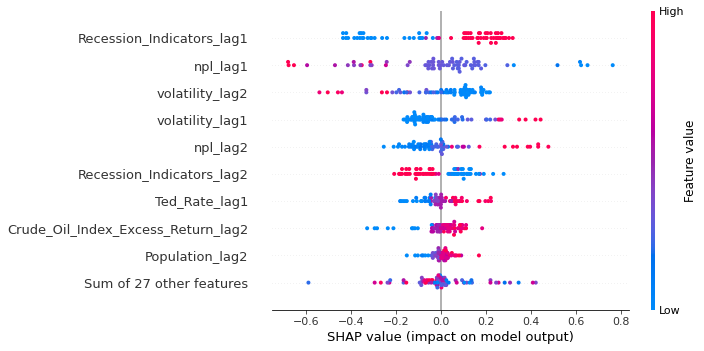

In [39]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

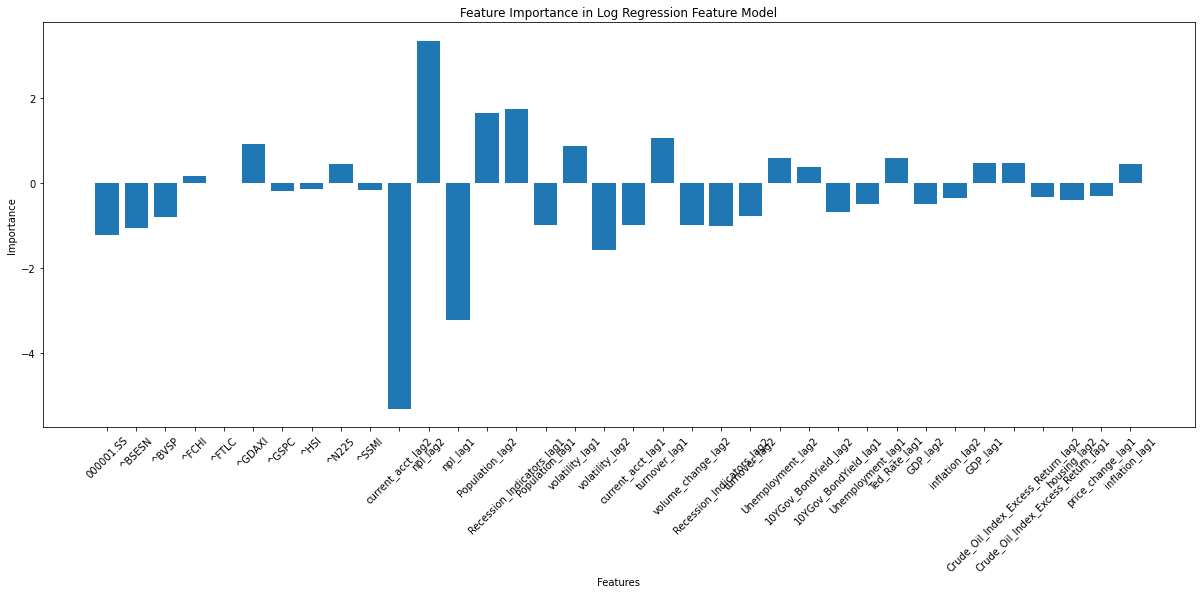

In [40]:
model_name = "Log Regression Feature"
plot_feature_importances(evaluation_df, model_name)

In [41]:
importance_columns = [col for col in evaluation_df.columns if col.endswith("_importance")]

# Calculate the average importance value for each feature
importance_avgs = evaluation_df[importance_columns].mean(axis=0)
cleaned_index = [index.replace("_importance", "") for index in importance_avgs.index]
importance_avgs = pd.Series(importance_avgs.values, index=cleaned_index)

In [42]:
importance_avgs

000001.SS                            -1.215689
^BSESN                               -1.061700
^BVSP                                -0.797487
^FCHI                                 0.157065
^FTLC                                 0.008975
^GDAXI                                0.919147
^GSPC                                -0.178944
^HSI                                 -0.133158
^N225                                 0.454038
^SSMI                                -0.168679
current_acct_lag2                    -5.311871
npl_lag2                              3.346659
npl_lag1                             -3.215670
Population_lag2                       1.639864
Recession_Indicators_lag1             1.743916
Population_lag1                      -0.994049
volatility_lag1                       0.866759
volatility_lag2                      -1.578363
current_acct_lag1                    -0.993457
turnover_lag1                         1.065887
volume_change_lag2                   -0.984012
Recession_Ind

## AUC-ROC

In [43]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.5625449144620667


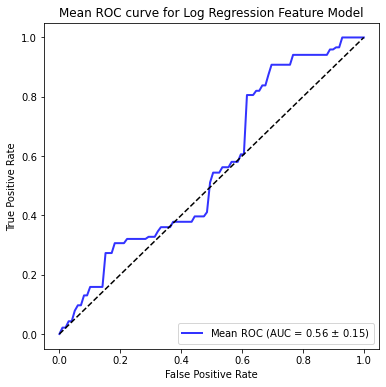

In [44]:
plot_roc_curve(evaluation_df, model_name)